# 🗣️ Sentiment Analysis: Aspect-Based Opinion Mining

http://colab.research.google.com

In [ ]:
https://github.com/twintproject/twint

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install vaderSentiment

In [ ]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from stop_words import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# read data
data = pd.read_json(r'/content/halal_vaccine_twint_07052021.json', lines = True)

# remove non-english
data = data.loc[data['language'] == 'en']

raw_data = []
for i in data['tweet']:
  raw_data.append(i)

df = pd.DataFrame(raw_data, columns =['reviews'])
display(df)

,reviews
0,Did anyone have any side effects to their seco...
1,@Leen28786102 @alzassociation They've been mak...
2,Medical advice for muslims on vaccines during ...
3,@DrSaimakhan3 @tufailelif Can this reach d mol...
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...
...,...
4862,@earthforce_1 @AishathHepburn @JannahsForever ...
4863,@earthforce_1 @AishathHepburn @JannahsForever ...
4864,@_Halaby @AishathHepburn @JannahsForever @Told...
4865,@earthforce_1 @AishathHepburn @JannahsForever ...


In [ ]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

#df['remove_lower_punct'] = df['reviews'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()
#drop non-english
#df.drop(df.loc[df['language' != "en"]], inplace = True)
#
#df.loc[df['Dominant_topic'] == 2]

#lower case
df['remove_lower_punct'] = df['reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove URL
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'www\.\S+\.com','')

#removes retweets & cc
#df['tweet'] = df['tweet'].str.replace(r'rt|cc', '')

#hashtags removes
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'#', '')

#user mention removes
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'@\S+', '')

#emoji 
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'[^\x00-\x7F]+', '')

#replace &amp
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace(r'&amp', 'and')

#Removing the Punctuation
df['remove_lower_punct'] = df['remove_lower_punct'].str.replace('[^\w\s]', '')

display(df.head(10))

,reviews,remove_lower_punct
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...


In [ ]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267


In [ ]:
# tokenise string
import nltk
nltk.download('punkt')
df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

display(df.head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h..."
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma..."


In [ ]:
# initiate stopwords from nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
import nltk
from nltk.corpus import words
nltk.download('words')
setofwords = set(words.words())

# add additional missing terms

#stop_words.extend(stop_words_list) 

# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words and item.isalpha() and item in setofwords])

display(df.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]"
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]"


In [ ]:
# initiate nltk lemmatiser
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(df.head(10))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt...","[anyone, side, effect, second, vaccine, didnt,..."
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ...","[making, corona, didnt, one, particular, one, ..."
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre...","[medical, advice, halal, getting, fasting, bre..."
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert...","[reach, shouting, pulpit, vaccine, halal, cert..."
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai...","[antirabies, vaccine, stock, available, certai..."
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge...","[didnt, vaccination, year, category, party, ge..."
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus...","[nothing, least, medical, support, agreed, mus..."
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ...","[equipment, critical, focus, obtain, foreign, ..."
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]","[saying, vaccine, halal, know]"
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]","[jump, avenue, near, yummy, cuisine, halal]"


In [ ]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 863)	1
  (0, 15963)	1
  (0, 5065)	1
  (0, 15565)	1
  (0, 18969)	1
  (0, 4397)	1
  (1, 10778)	1
  (1, 3443)	1
  (1, 4405)	1
  (1, 12547)	1
  (1, 12823)	1
  (1, 12545)	1
  (1, 12246)	1
  (2, 11212)	1
  (2, 261)	1
  (2, 7714)	1
  (2, 6818)	1
  (2, 5891)	1
  (2, 1906)	1
  (2, 5881)	1
  (2, 13058)	1
  (2, 9314)	1
  (2, 12286)	1
  (2, 12387)	1
  (2, 3719)	1
  :	:
  (4865, 19104)	1
  (4865, 17611)	1
  (4865, 7447)	1
  (4865, 4910)	1
  (4865, 1145)	1
  (4865, 14916)	1
  (4865, 20260)	1
  (4865, 12354)	1
  (4865, 17556)	1
  (4865, 7374)	1
  (4865, 15456)	1
  (4865, 12041)	1
  (4865, 16436)	1
  (4865, 435)	1
  (4866, 9798)	1
  (4866, 6010)	1
  (4866, 17894)	1
  (4866, 22)	1
  (4866, 3310)	1
  (4866, 4667)	1
  (4866, 11581)	1
  (4866, 8775)	1
  (4866, 3807)	1
  (4866, 13245)	1
  (4866, 13498)	1


In [ ]:
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 7, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = [i for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,1_x,2_x,3_x,4_x,5_x,Dominant_topic_x,1_y,2_y,3_y,4_y,5_y,6,7,Dominant_topic_y
0,Did anyone have any side effects to their seco...,did anyone have any side effects to their seco...,Neutral,0.0000,"[did, anyone, have, any, side, effects, to, th...","[anyone, side, effects, second, vaccine, didnt...","[anyone, side, effect, second, vaccine, didnt,...",0.89,0.03,0.03,0.03,0.03,1,0.02,0.02,0.02,0.02,0.02,0.88,0.02,6
1,@Leen28786102 @alzassociation They've been mak...,theyve been making vaccines for corona virus...,Neutral,0.0000,"[theyve, been, making, vaccines, for, corona, ...","[making, corona, didnt, one, particular, one, ...","[making, corona, didnt, one, particular, one, ...",0.03,0.03,0.03,0.90,0.03,4,0.02,0.02,0.02,0.02,0.02,0.89,0.02,6
2,Medical advice for muslims on vaccines during ...,medical advice for muslims on vaccines during ...,Negative,-0.2960,"[medical, advice, for, muslims, on, vaccines, ...","[medical, advice, halal, getting, fasting, bre...","[medical, advice, halal, getting, fasting, bre...",0.01,0.01,0.01,0.95,0.01,4,0.01,0.01,0.01,0.01,0.01,0.94,0.01,6
3,@DrSaimakhan3 @tufailelif Can this reach d mol...,can this reach d molbis shouting from pulpit...,Positive,0.7269,"[can, this, reach, d, molbis, shouting, from, ...","[reach, shouting, pulpit, vaccine, halal, cert...","[reach, shouting, pulpit, vaccine, halal, cert...",0.01,0.95,0.01,0.01,0.01,2,0.01,0.95,0.01,0.01,0.01,0.01,0.01,2
4,@AnjuPankaj3 Is #AntiRabies Vaccine Out of Sto...,is antirabies vaccine out of stock or is it a...,Positive,0.2732,"[is, antirabies, vaccine, out, of, stock, or, ...","[antirabies, vaccine, stock, available, certai...","[antirabies, vaccine, stock, available, certai...",0.02,0.02,0.02,0.93,0.02,4,0.01,0.01,0.01,0.92,0.01,0.01,0.01,4
5,@PrasanthSbjp @narendramodi @drharshvardhan ...,kerala didnt started vaccination for below ...,Positive,0.8338,"[kerala, didnt, started, vaccination, for, bel...","[didnt, vaccination, year, category, party, ge...","[didnt, vaccination, year, category, party, ge...",0.90,0.03,0.03,0.03,0.03,1,0.89,0.02,0.02,0.02,0.02,0.02,0.02,1
6,@SalmanNizami_ Nothing wrong!At least there is...,nothing wrongat least there is medical suppor...,Positive,0.9274,"[nothing, wrongat, least, there, is, medical, ...","[nothing, least, medical, support, agreed, mus...","[nothing, least, medical, support, agreed, mus...",0.96,0.01,0.01,0.01,0.01,1,0.96,0.01,0.01,0.01,0.01,0.01,0.01,1
7,"O² equipment, critical medicines focus of Indi...",o equipment critical medicines focus of indias...,Positive,0.1027,"[o, equipment, critical, medicines, focus, of,...","[equipment, critical, focus, obtain, foreign, ...","[equipment, critical, focus, obtain, foreign, ...",0.01,0.01,0.01,0.95,0.01,4,0.01,0.01,0.01,0.95,0.01,0.01,0.01,4
8,@AnjumAaqib Are you saying this vaccine is hal...,are you saying this vaccine is halal how do y...,Neutral,0.0000,"[are, you, saying, this, vaccine, is, halal, h...","[saying, vaccine, halal, know]","[saying, vaccine, halal, know]",0.05,0.05,0.80,0.05,0.05,3,0.04,0.04,0.79,0.04,0.04,0.04,0.04,3
9,[ON] Toronto Rexdale Jump on it 40+ Walmart 22...,on toronto rexdale jump on it 40 walmart 2245 ...,Positive,0.5267,"[on, toronto, rexdale, jump, on, it, 40, walma...","[jump, avenue, near, yummy, cuisine, halal]","[jump, avenue, near, yummy, cuisine, halal]",0.03,0.03,0.03,0.03,0.87,5,0.02,0.02,0.02,0.02,0.86,0.02,0.02,5


In [ ]:
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
aa going,6,1.142857
aa vaccine,7,1.143019
abbas message,3,1.142724
abey talk,3,1.142857
able book,1,1.142857
...,...,...
zero contribution,4,1.142857
zero research,1,1.142857
zero success,1,1.142857
zombie demanding,1,1.142856


In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,7,[halal status]
1,8,[amid halal]
2,4,[halal await]
3,2,[vaccine halal]
4,6,[halal vaccine]
5,3,[filled cow]
6,5,[experimental vaccine]


In [ ]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
halal ruling,214,244,359
halal status,214,267,315
halal vaccine,169,256,248
vaccine halal,233,477,337


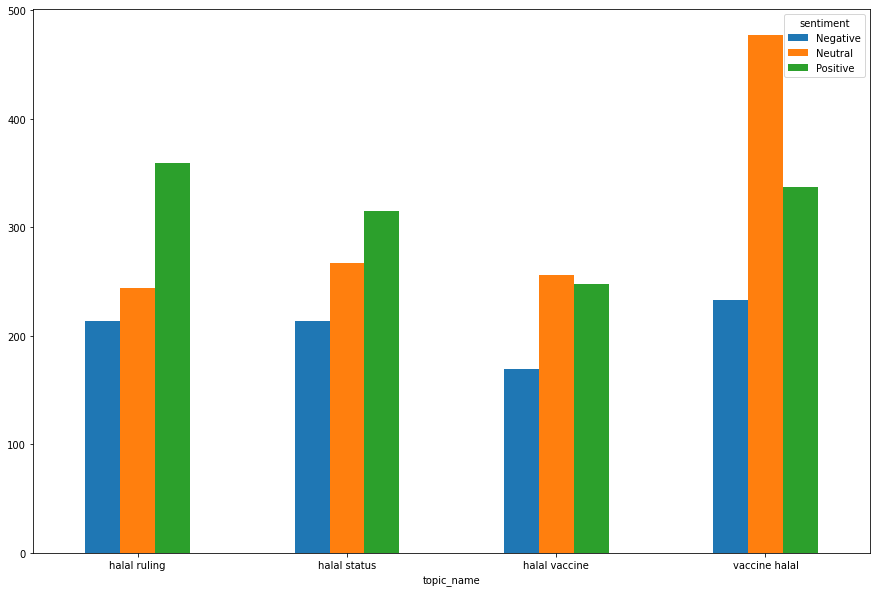

In [ ]:
fig = graph_results.plot.bar(rot=0, figsize=(15,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

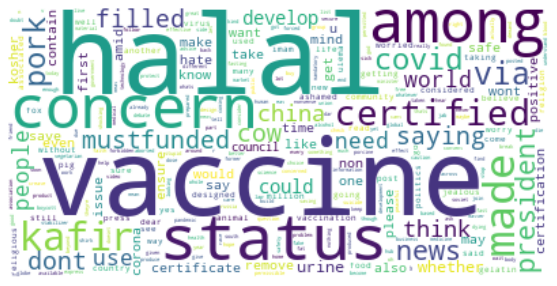

<Figure size 432x288 with 0 Axes>

In [ ]:
tmp3 = []
tmp1 = df.loc[df['Dominant_topic'] == 2]
tmp2 = tmp1['lemmatise'].values.tolist()
for i in tmp2:
  tmp3.extend(i)
fdist = nltk.FreqDist(tmp3)
word_dict = {}
for key in fdist:
    #print ("'%s' occurred %s times" % (key, fdist[key]))
    word_dict[key] = fdist[key]

wordCloud = WordCloud(max_words=500, background_color='white').generate_from_frequencies(word_dict)
plt.figure(figsize=(10,5))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("topic_1.png", dpi=1200)

In [ ]:
!pip install text2emotion

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 133kB 9.1MB/s 


In [ ]:
import text2emotion as te
angry = fear = happy = sad = surprise = 0.00
count = 1
count_all_zero = 0
sad_txt = []
for row in df['remove_lower_punct']:
  emotion = te.get_emotion(row)
  if emotion['Angry'] == 0 and emotion['Fear'] == 0 and emotion['Happy'] == 0 and emotion['Sad'] == 0 and emotion['Surprise'] == 0:
    count_all_zero = count_all_zero + 1
  else:
    angry = angry + emotion['Angry']
    fear = fear + emotion['Fear']
    happy = happy + emotion['Happy']
    sad = sad + emotion['Sad']
    surprise = surprise + emotion['Surprise']
    max_emotion = max(emotion, key = emotion.get)
    if max_emotion == 'Sad':
      sad_txt.append(row)
    count = count + 1
    print(count)
  print(emotion)
print(f"Angry is {angry/count} and fear is {fear/count} and happy is {happy/count} and sad is {sad/count} and surprise is {surprise/count}")
print(f'All zero = {count_all_zero}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 1.0, 'Sad': 0.0, 'Fear': 0.0}
3
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.5, 'Fear': 0.5}
4
{'Happy': 0.0, 'Angry': 0.5, 'Surprise': 0.5, 'Sad': 0.0, 'Fear': 0.0}
5
{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.5, 'Sad': 0.0, 'Fear': 0.25}
6
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.25, 'Fear': 0.75}
7
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}
8
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.25, 'Sad': 0.0, 'Fear': 0.75}
9
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.33, 'Sad': 0.0, 'Fear': 0.67}
10
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 1.0, 'Sad': 0.0, 'F

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
emotion_data = {'Angry': angry/count, 'Fear': fear/count, 'happy': happy/count, 'Sad': sad/count, 'Surprise': surprise/count}
df2 = pd.DataFrame(emotion_data, index=[1])
print(df2)

In [ ]:
all_words = []
true_words = []
final_words = []
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'via', 'u', 'like', 'let', 'yes', 'non']
from nltk.corpus import words
import nltk
nltk.download('words')
setofwords = set(words.words())

for sentence in sad_txt:
  all_words.extend(nltk.word_tokenize(sentence))

for item in all_words:
  if item not in stop_words and item.isalpha() and item in setofwords and item not in numbers:
    true_words.append(item)

# for item in true_words:
#   lem = wordnet_lemmatizer.lemmatize(item)
#   final_words.append(lem)

words_dist = nltk.FreqDist(true_words)
word_dicti = {}
for key in words_dist:
    word_dicti[key] = words_dist[key]

print(dict(sorted(word_dicti.items(), key=lambda item: item[1])))

In [ ]:
import csv
with open('sad_txt_twitter.csv', 'w+') as output:
    writer = csv.writer(output)
    for key, value in word_dicti.items():
        writer.writerow([key, value])

In [ ]:
# from nltk.corpus import wordnet
# nltk.download('averaged_perceptron_tagger')
# nltk.download('sentiwordnet')

# def get_wordnet_pos(treebank_tag):

#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         pass

# positive_words = []
# negative_words = []

# for i in df['Dominant_topic'].unique():
#     if i == 1:
#         tmp_1 = df.loc[df['Dominant_topic'] == i]
                
#         for j in tmp_1['tokenise'].values.tolist():
#             for p in nltk.pos_tag(j):
#                 get_pos_tag = get_wordnet_pos(p[1])
#                 if type(get_pos_tag) == str:
#                     try:
#                         synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')
                        
#                         if synset.obj_score() <= 0.49:
#                             if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
#                                     positive_words.append(p[0])
#                             elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
#                                     negative_words.append(p[0])      
#                     except:
#                         pass
# print(negative_words)
# print(positive_words)

In [ ]:
# unique_positive_words = list(set(positive_words))
# unique_negative_words = list(set(negative_words))

# count_positive_words = []
# count_negative_words = []

# for i in unique_positive_words:
#     counter = [i, positive_words.count(i)]
#     count_positive_words.append(counter)

# for i in unique_negative_words:
#     counter = [i, negative_words.count(i)]
#     count_negative_words.append(counter)    
    
# positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
# negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

# positive_words.sort_values('score', ascending=False, inplace = True)
# negative_words.sort_values('score', ascending=False, inplace = True)
# print(negative_words)

In [ ]:
# word_dict = {}
# for k, v in positive_words.values:
#     word_dict[k] = v

# wordcloud = WordCloud()
# wordcloud.generate_from_frequencies(frequencies=word_dict)
# plt.figure(figsize=(10,5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.savefig('positive_words.png')
# plt.show()

In [ ]:
# word_dict = {}
# for k, v in negative_words.values:
#     word_dict[k] = v
    
# wordcloud.generate_from_frequencies(frequencies=word_dict)
# plt.figure(figsize=(10,5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.savefig('negative_words.png')
# plt.show()